In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
from keras.preprocessing.image import load_img
from IPython.display import Image,display
from PIL import ImageDraw
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array,array_to_img
from IPython.display import Image,display

import pickle
import time

In [2]:
df = pickle.load(open('Data/feature_matrix/DF20000_bbox.p','rb'))

In [3]:
fc6_full = pickle.load(open('Data/feature_matrix/FC6_full_trained.p','rb'))


In [27]:
def draw_bbox(bbox):
    img = PIL.Image.open('Data/DeepFashion/'+bbox['image_name']).convert('RGBA')
    
    lx = bbox['x_1']
    ly = bbox['y_1']
    ux = bbox['x_2']
    uy = bbox['y_2']
    rect = PIL.Image.new('RGBA', img.size, (255,255,255,0))
    d = ImageDraw.Draw(img)
    d.rectangle(((lx,ly), (ux,uy)), outline="red")
    return PIL.Image.alpha_composite(img,rect)

def find_neighbors(img_feature,image_df,feature_matrix,k=1,metric='L2'):

    if metric == 'L2':
        dist = np.sum((feature_matrix-img_feature)**2,axis=1)
    elif metric == 'L1':
        dist = np.sum(np.abs(feature_matrix-img_feature),axis=1)
    elif metric == 'H':
        bin_mat = (feature_matrix > 0)
        img_feature = (img_feature>0)
        dist = np.sum(np.logical_xor(img_feature,bin_mat),axis=1)
        
    j=1
    match = np.argsort(dist)[j:(j+k)]
    while dist[match[0]]<=0:
        j += 1
        match = np.argsort(dist)[j:(j+k)]
        
    return match
        
        
def img_diff(image_df,feature_matrix):
    i = np.random.randint(image_df.shape[0],size=1)[0]
    img_feature = feature_matrix[i,:]
    display(draw_bbox(image_df.iloc[i]))
    
    n = find_neighbors(img_feature,df,feature_matrix)[0]
    display(draw_bbox(image_df.iloc[n]))
    
    d = find_neighbors(img_feature-feature_matrix[n,:],image_df,feature_matrix)[0]
    display(draw_bbox(image_df.iloc[d]))

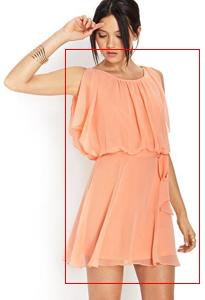

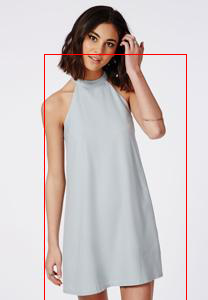

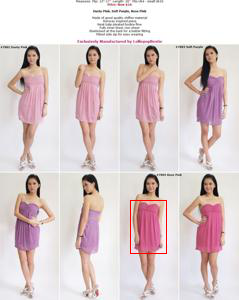

In [35]:
img_diff(df,fc6_full)

In [36]:
def img_path(image_df,feature_matrix,N):
    i = np.random.randint(image_df.shape[0],size=2)
    s_feature = feature_matrix[i[0],:]
    d_feature = feature_matrix[i[1],:]
    display(draw_bbox(image_df.iloc[i[0]]))
    
    sep = d_feature-s_feature
    #dist = np.sqrt(np.sum((sep)**2))
    
    for j in range(N):
        img_feature = sep*j/N
        n = find_neighbors(img_feature,df,feature_matrix)[0]
        display(draw_bbox(image_df.iloc[n]))
    
    display(draw_bbox(image_df.iloc[i[1]]))

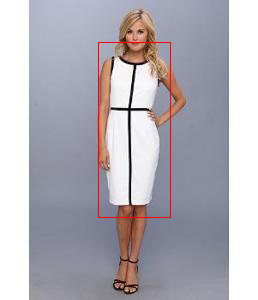

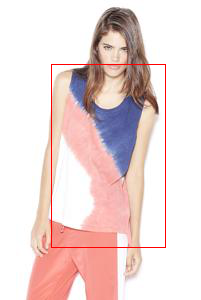

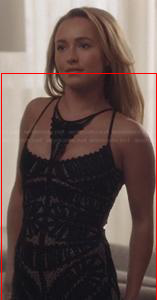

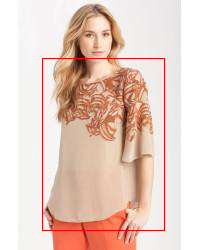

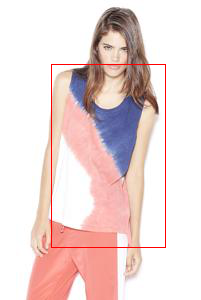

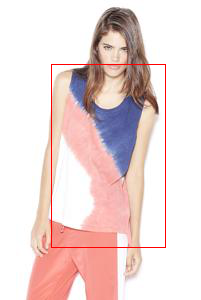

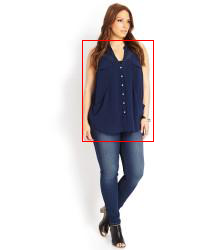

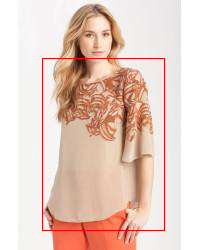

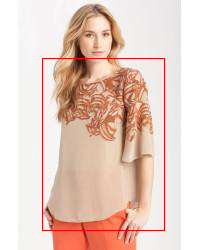

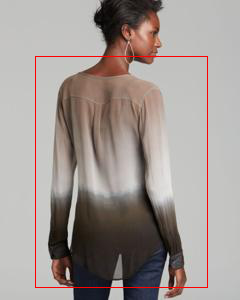

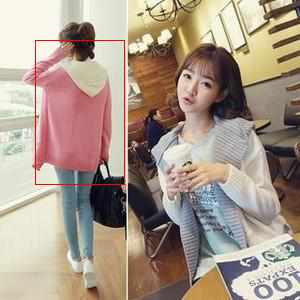

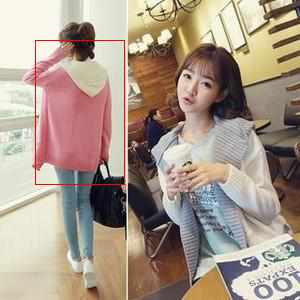

In [39]:
img_path(df,fc6_full,10)

In [56]:
def find_neighbors_dist(img_feature,image_df,feature_matrix,k=1,metric='L2'):

    if metric == 'L2':
        dist = np.sum((feature_matrix-img_feature)**2,axis=1)
    elif metric == 'L1':
        dist = np.sum(np.abs(feature_matrix-img_feature),axis=1)
    elif metric == 'H':
        bin_mat = (feature_matrix > 0)
        img_feature = (img_feature>0)
        dist = np.sum(np.logical_xor(img_feature,bin_mat),axis=1)
        
    j=1
    match = np.argsort(dist)[j:(j+k)]
    while dist[match[0]]<=0:
        j += 1
        match = np.argsort(dist)[j:(j+k)]
        
    return match,dist[match]

In [40]:
import networkx as nx
G = nx.Graph()

In [46]:
G.add_nodes_from(list(range(20)))

In [64]:
import time
start = time.time()
for i in range(20):
    find_neighbors_dist(fc6_full[i],df,fc6_full,50)
print(time.time()-start)

5.470471143722534


In [128]:
l = fc6_full.shape[0]
f = fc6_full
bin_mat = (fc6_full > 0)

In [129]:
start = time.time()

d = np.empty((l,l))
for i in range(l):
    d[i,:] = np.sum(np.logical_xor(bin_mat[i],bin_mat),axis=1)
    
print(time.time()-start)

3457.313117980957


In [159]:
pickle.dump(d,open('Data/feature_matrix/fc6_full_H_dist.p','wb'))

OSError: [Errno 22] Invalid argument

In [130]:
e = np.argwhere(d<700)

In [131]:
edges = np.append(e,d[e[:,0],e[:,1]].reshape(-1,1),1).astype('int64')

In [132]:
G = nx.Graph()
G.add_nodes_from(np.unique(e))
G.add_weighted_edges_from(edges)

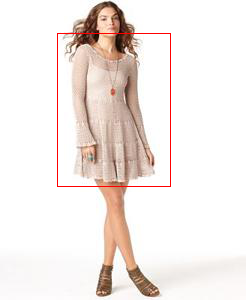

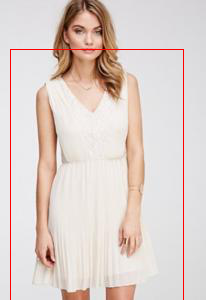

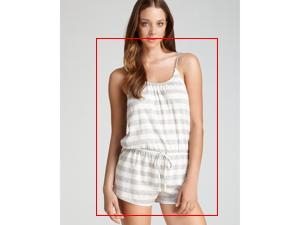

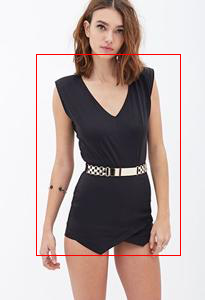

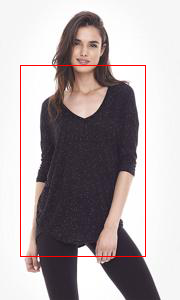

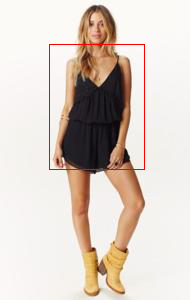

In [152]:
i = np.random.randint(df.shape[0],size=2)
while not nx.has_path(G,i[0],i[1]):
    i = np.random.randint(df.shape[0],size=2)

p = nx.shortest_path(G,i[0],i[1])
for i in p:
    display(draw_bbox(df.iloc[i]))

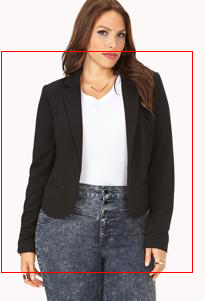

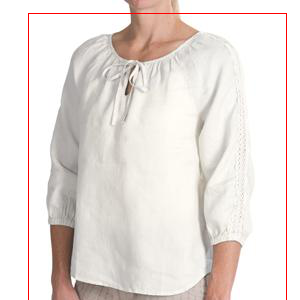

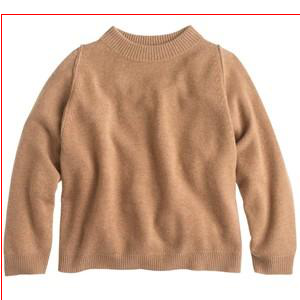

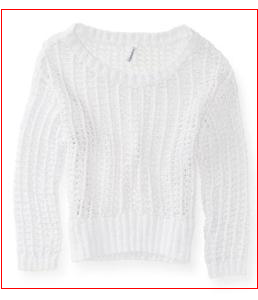

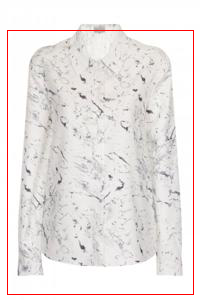

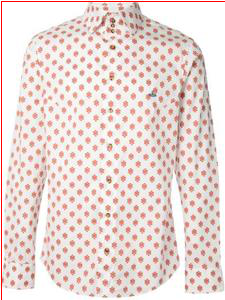

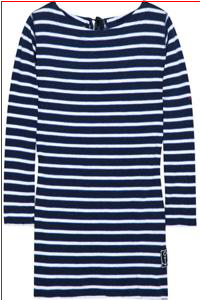

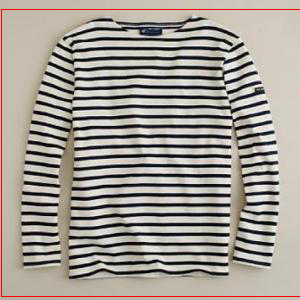

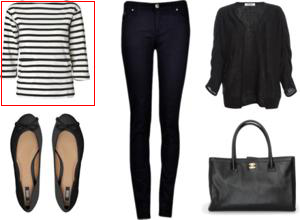

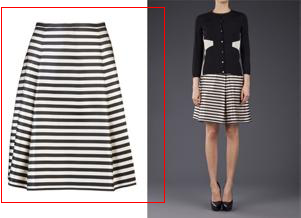

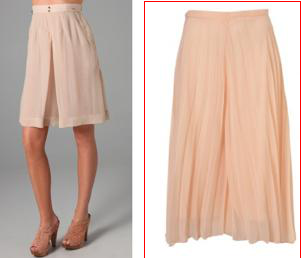

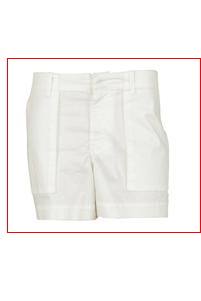

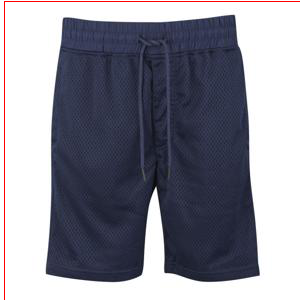

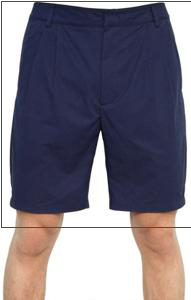

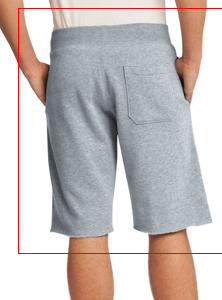

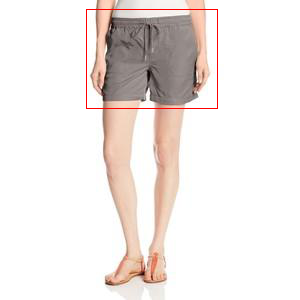

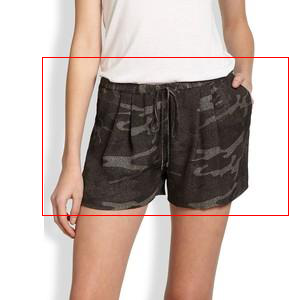

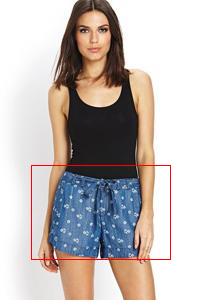

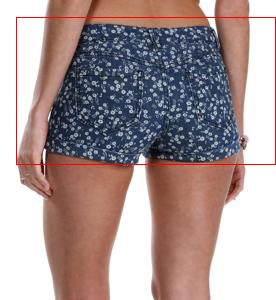

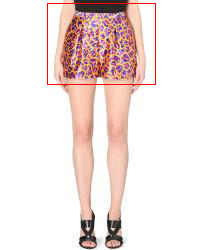

In [145]:
for i in p:
    display(draw_bbox(df.iloc[i]))

In [157]:
pos=nx.graphviz_layout(G,prog='sfdp')

AttributeError: module 'networkx' has no attribute 'graphviz_layout'

In [153]:
nx.draw_networkx(G)

KeyboardInterrupt: 

In [158]:
import pygraphviz

ModuleNotFoundError: No module named 'pygraphviz'